In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import boston_housing
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

print(tf.__version__)


2.6.0


In [2]:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()


In [3]:
# drop a column

col_drop = X_train.shape[1]-1
X_train_D = np.delete(X_train, col_drop, 1 ) 
X_test_D = np.delete(X_test, col_drop, 1 ) 

In [4]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

def gen(train_features, train_labels, test_features, test_labels, custom_weights=None):
    train_mean = np.mean(train_features, axis=0)
    train_std = np.std(train_features, axis=0)
    train_features = (train_features - train_mean) / train_std
    
    # Build model
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(train_features[0])]),
        Dense(1)
    ])

    model.compile(optimizer=tf.optimizers.Adam(), 
                  loss='mse',
                  metrics=['mae', 'mse'])
    
    if type(custom_weights) != type(None):
        # Set custom init weights
        w, b = custom_weights
        model.layers[0].set_weights([w,b])
        pass
    
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model.fit(train_features, train_labels, epochs=100, verbose=0, validation_split = 0.1,
                        callbacks=[early_stop, PrintDot()])

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    # show RMSE measure to compare to Kaggle leaderboard on https://www.kaggle.com/c/boston-housing/leaderboard
    cm = tf.math.confusion_matrix(test_labels, model.predict(test_features))
    results = model.evaluate(train_features, train_labels)
    print("train loss, train acc:", results)
    results = model.evaluate(test_features, test_labels)
    print("test loss, test acc:", results)

    plot_history(hist)
    return hist, model

def plot_history(hist):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [Thousand Dollars$^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    #plt.ylim([0,50])



13/13 [==============================] - 0s 2ms/step - loss: 24.0359 - mae: 3.5740 - mse: 24.0359..
train loss, train acc: [24.035886764526367, 3.574005365371704, 24.035886764526367]
4/4 [==============================] - 0s 979us/step - loss: 3677290.7500 - mae: 1903.0013 - mse: 3677290.7500
test loss, test acc: [3677290.75, 1903.0013427734375, 3677290.75]


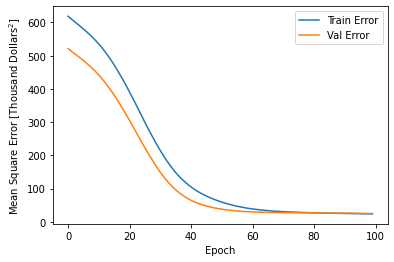

In [5]:
hist_1, model_1 = gen(X_train, y_train, X_test, y_test)


13/13 [==============================] - 0s 908us/step - loss: 28.2405 - mae: 3.6532 - mse: 28.2405
train loss, train acc: [28.24050521850586, 3.6531832218170166, 28.24050521850586]
4/4 [==============================] - 0s 1ms/step - loss: 2131021.5000 - mae: 1443.1743 - mse: 2131021.5000
test loss, test acc: [2131021.5, 1443.17431640625, 2131021.5]


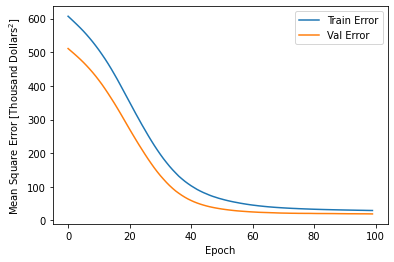

In [6]:
hist_2, model_2 = gen(X_train_D, y_train, X_test_D, y_test)

In [7]:
# Create new weights with bias from model

w, b = model_2.layers[0].get_weights()
w = np.array(w)
b = np.array(b)
w_new = np.vstack((w, np.zeros((1, model_2.weights[0].shape[1]) ) ))
w_new.shape, w.shape, b.shape

((13, 20), (12, 20), (20,))


13/13 [==============================] - 0s 851us/step - loss: 18.8914 - mae: 3.1314 - mse: 18.8914
train loss, train acc: [18.891399383544922, 3.1313841342926025, 18.891399383544922]
4/4 [==============================] - 0s 1ms/step - loss: 2355337.5000 - mae: 1508.2631 - mse: 2355337.5000
test loss, test acc: [2355337.5, 1508.2630615234375, 2355337.5]


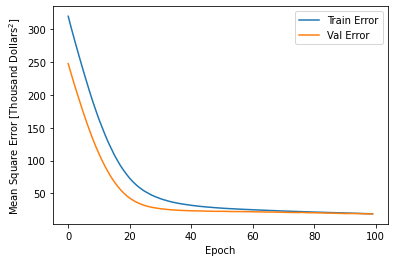

In [8]:
hist_3, model_3 = gen(X_train, y_train, X_test, y_test, custom_weights=[w_new,b])